In [7]:
import sys
import numpy as np
import pandas as pd
import scipy as sc
from scipy.stats import mannwhitneyu, zscore, ttest_ind, ttest_ind_from_stats, \
                        f_oneway, wilcoxon, kruskal, friedmanchisquare
from statsmodels.stats import weightstats as stests
import matplotlib.pyplot as plt

sys.path.append("../")

from src.ab.helpers import min_sample_size_avg

%matplotlib inline

MDE = 0.02
beta = 0.2
alpha = 0.07

In [8]:
class LogNormalGenerator():
    def __init__(self,
                 mean,
                 std):
        self.mean = mean
        self.std = std
    def get_sample(self,
                   size):
        return np.random.lognormal(mean=self.mean, 
                                   sigma=self.std, 
                                   size=size)*1000

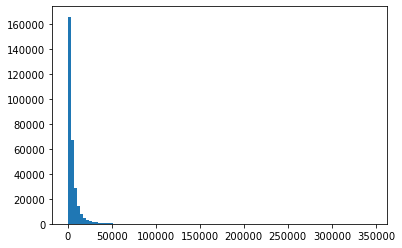

Mean and std on historical data: 5492.099766694561, 8432.533209796626
Recommended sample size: 82996


In [9]:
mu, sd = 1.1, 1.1
generator = LogNormalGenerator(mean=mu,
                               std=sd)
retro_data = generator.get_sample(size=300000)
plt.hist(retro_data,
         bins=100)
plt.show()
sample_mean, sample_std = retro_data.mean(), retro_data.std()
print("Mean and std on historical data: {}, {}".format(sample_mean, sample_std))
#calc estimated sample size
sample_size = int(min_sample_size_avg(sample_std,
                                      retro_data.mean()*MDE,
                                      power=1-beta,
                                      sig_level=alpha))
print("Recommended sample size: {}".format(sample_size))

In [10]:
def check_stat_errors(size,
                      n_experiments,
                      MDE):
    #generate experiment data
    experiment_data = np.array([[generator.get_sample(size=size), 
                                 generator.get_sample(size=size)] for i in range(n_experiments)])
    #data + effect 
    add_effects = lambda x: np.array([np.array([i[0], 
                                                i[1]+np.random.normal(i[1].mean() * MDE,
                                                                      i[1].std() / 10,
                                                                      len(i[1]))]) for i in x])
    experiment_data_effect_added = add_effects(experiment_data)
    
    #define some useful functions
    
    def calc_all_criterias(x, y):
        tt_pval = ttest_ind(a=x, b=y, equal_var=True)[1]
        mw_pval = mannwhitneyu(x=x, y=y).pvalue
        zt_pval = stests.ztest(x1=x, x2=y)[1]
        anova_pval = f_oneway(x, y)[1]
        wilcoxon_pval = wilcoxon(x, y)[1]
        kruskal_pval = kruskal(x, y)[1]
        return [tt_pval, mw_pval, zt_pval, anova_pval, 
                wilcoxon_pval, kruskal_pval]
        
    stat_calc = lambda x: np.array([np.array(calc_all_criterias(i[0], i[1])) for i in x])
    p_values = stat_calc(experiment_data)
    #calc i type errors
    i_type_calc = lambda x: [len(i[i<alpha])/len(i) for i in x]
    i_type_errors = i_type_calc(p_values.T)
    #calc ii type errors
    p_values_ii_type_error = stat_calc(experiment_data_effect_added)
    ii_type_calc = lambda x: [len(i[i>alpha])/len(i) for i in x]
    ii_type_errors = ii_type_calc(p_values_ii_type_error.T)
    
    return i_type_errors+ii_type_errors

#### Errors vs sample size

In [11]:
n_experiments = 1000
start = 100
if sample_size < 2000:
    step = 200
elif sample_size >= 2000 and sample_size< 10000:
    step = 500
elif sample_size >= 10000 and sample_size< 30000:
    step = 1000
else:
    step=5000
num=int(sample_size/step)+3

sizes=np.arange(0,num)*step+start
error_per_sample_size = []

for size in sizes:
    print(size)
    i_type_error_tt, i_type_error_mw, i_type_error_tz, i_type_error_anova, i_type_wilcoxon, i_type_kruskal, \
    ii_type_error_tt, ii_type_error_mw, ii_type_error_tz, ii_type_error_anova, ii_type_wilcoxon, ii_type_kruskal = check_stat_errors(size=size,
                                                                                             n_experiments=n_experiments,
                                                                                             MDE=MDE)
    error_per_sample_size.append([size, sample_size, i_type_error_tt, i_type_error_mw, \
                                  i_type_error_tz, i_type_error_anova, i_type_wilcoxon, i_type_kruskal, \
        ii_type_error_tt, ii_type_error_mw, ii_type_error_tz, ii_type_error_anova, ii_type_wilcoxon, ii_type_kruskal])

100
5100
10100
15100
20100
25100
30100
35100
40100
45100
50100
55100
60100
65100
70100
75100
80100
85100
90100


In [12]:
res = pd.DataFrame(error_per_sample_size, columns = ['size', 'recommended_sample_size', 'i_type_error_tt', 'i_type_error_mw', \
                                  'i_type_error_tz', 'i_type_error_anova', 'i_type_wilcoxon', 'i_type_kruskal', \
                                    'ii_type_error_tt', 'ii_type_error_mw', 'ii_type_error_tz', \
                                                     'ii_type_error_anova', 'ii_type_wilcoxon', 'ii_type_kruskal'] )
res

,size,recommended_sample_size,i_type_error_tt,i_type_error_mw,i_type_error_tz,i_type_error_anova,i_type_wilcoxon,i_type_kruskal,ii_type_error_tt,ii_type_error_mw,ii_type_error_tz,ii_type_error_anova,ii_type_wilcoxon,ii_type_kruskal
0,100,82996,0.077,0.149,0.079,0.077,0.077,0.087,0.922,0.830,0.921,0.922,0.924,0.914
1,5100,82996,0.063,0.133,0.063,0.063,0.063,0.073,0.897,0.350,0.897,0.897,0.689,0.487
2,10100,82996,0.091,0.138,0.091,0.091,0.077,0.074,0.797,0.105,0.797,0.797,0.430,0.169
3,15100,82996,0.068,0.141,0.068,0.068,0.066,0.065,0.767,0.023,0.767,0.767,0.282,0.056
4,20100,82996,0.085,0.153,0.085,0.085,0.081,0.078,0.674,0.010,0.674,0.674,0.176,0.023
5,25100,82996,0.075,0.131,0.075,0.075,0.068,0.066,0.627,0.004,0.627,0.627,0.088,0.007
6,30100,82996,0.073,0.152,0.073,0.073,0.074,0.079,0.563,0.001,0.563,0.563,0.067,0.001
7,35100,82996,0.081,0.138,0.081,0.081,0.080,0.067,0.547,0.000,0.547,0.547,0.048,0.000
8,40100,82996,0.067,0.126,0.067,0.067,0.062,0.066,0.477,0.000,0.477,0.477,0.013,0.000
9,45100,82996,0.072,0.161,0.072,0.072,0.084,0.079,0.459,0.000,0.459,0.459,0.009,0.000


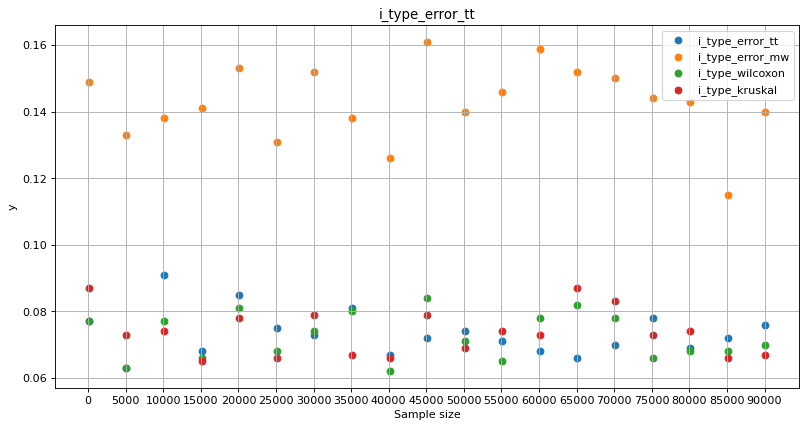

In [14]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=res['size'],
            y=res['i_type_error_tt'],
            label = "i_type_error_tt")
plt.scatter(x=res['size'],
            y=res['i_type_error_mw'],
            label = "i_type_error_mw")
plt.scatter(x=res['size'],
            y=res['i_type_wilcoxon'],
            label = "i_type_wilcoxon")
plt.scatter(x=res['size'],
            y=res['i_type_kruskal'],
            label = "i_type_kruskal")
plt.legend()
plt.title('i_type_error_tt')
plt.xlabel("Sample size")
plt.ylabel('y')
plt.grid()
plt.xticks(np.arange(0, res['size'].max(), step=5000))

plt.show()